In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib as mpl 

In [17]:
#3 dfs
# data_g -> datos completos
# data_n -> datos sin leaders
# data_l -> datos solo leaders
data_g = pd.read_csv('../data/data_global.csv')
data_n = pd.read_csv('../data/data_no_leaders.csv')
data_l = pd.read_csv('../data/data_leaders.csv')

In [18]:
data_n['Engagement'].describe()

count    10226.000000
mean         2.990006
std          0.993117
min          0.000000
25%          2.520000
50%          3.070000
75%          3.600000
max          5.000000
Name: Engagement, dtype: float64

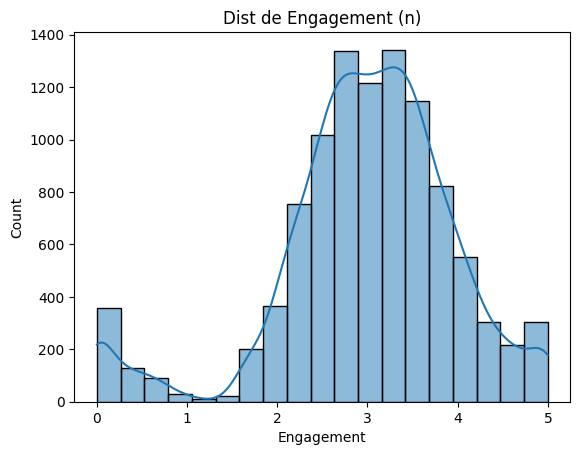

In [19]:
sns.histplot(data_n['Engagement'], bins=19, kde=True)
plt.title("Dist de Engagement (n)")
plt.show()

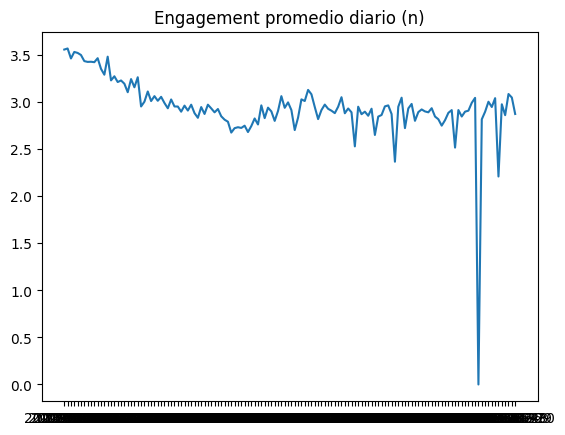

In [20]:
# Promedio diario por fecha
eng = (data_n.groupby('DateDT')['Engagement'].mean().reset_index())

plt.plot(eng['DateDT'], eng['Engagement'])
plt.title("Engagement promedio diario (n)")
plt.show()

Hipotesis El punto de inflexion es semana santa y pascua

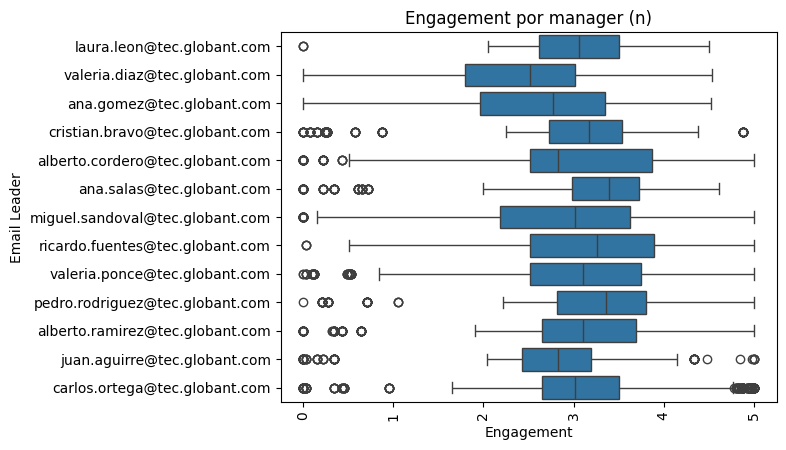

In [21]:
sns.boxplot(y="Email Leader", x='Engagement', data=data_n)
plt.title("Engagement por manager (n)")
plt.xticks(rotation=90)
plt.show()

In [22]:
data_n.dropna(inplace=True)

In [23]:
data_g["DateDT"] = pd.to_datetime(data_g["DateDT"])
data_n["DateDT"] = pd.to_datetime(data_n["DateDT"])
data_l["DateDT"] = pd.to_datetime(data_l["DateDT"])

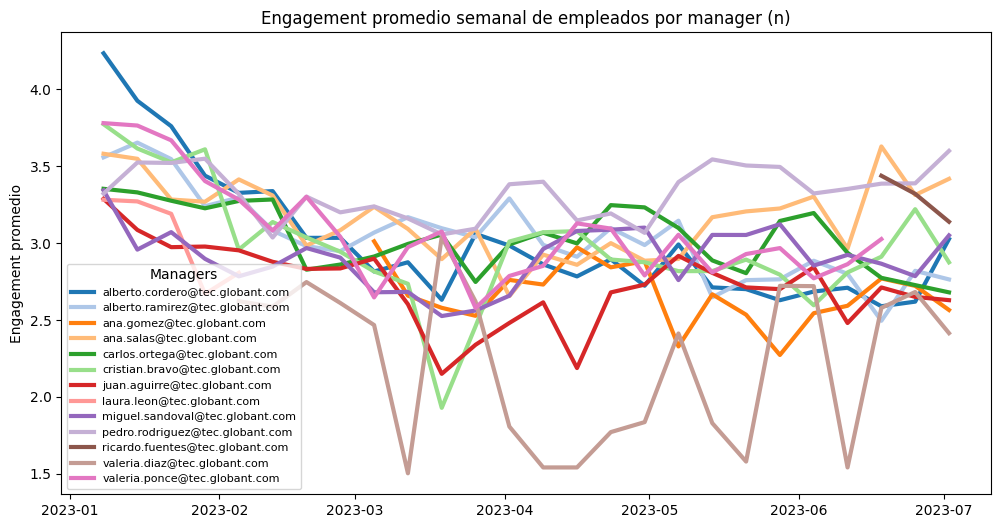

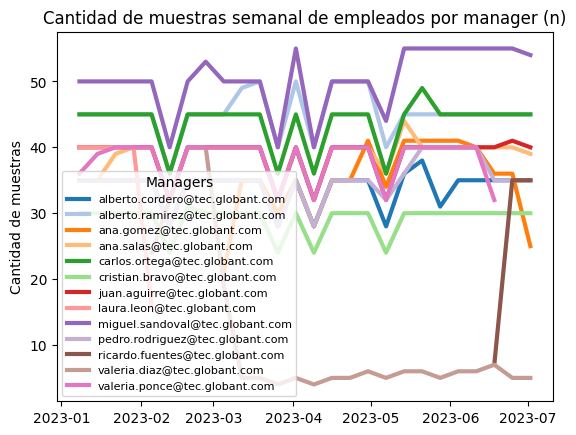

In [24]:
eng_mgr = (
    data_n
    .set_index("DateDT")
    .groupby("Email Leader")
    .resample("W")
    .agg(
        mean_eng=("Engagement", "mean"),
        n_scores=("Engagement", "size")
    )
    .reset_index()
)

managers = eng_mgr["Email Leader"].unique()
palette = sns.color_palette("tab20", n_colors=len(managers))
color_map = dict(zip(managers, palette))

plt.figure(figsize=(12,6))

for mid, df_m in eng_mgr.groupby("Email Leader"):
    plt.plot(
        df_m["DateDT"], 
        df_m["mean_eng"],        
        linewidth=3,
        alpha=1,
        color=color_map[mid],
        label=str(mid)
    )

plt.title("Engagement promedio semanal de empleados por manager (n)")
plt.ylabel("Engagement promedio")
plt.legend(title="Managers", fontsize=8)
plt.show()


for mid, df_m in eng_mgr.groupby("Email Leader"):
    plt.plot(
        df_m["DateDT"], 
        df_m["n_scores"],        
        linewidth=3,
        alpha=1,
        color=color_map[mid],
        label=str(mid)
    )

plt.title("Cantidad de muestras semanal de empleados por manager (n)")
plt.ylabel("Cantidad de muestras")
plt.legend(title="Managers", fontsize=8)
plt.show()

In [25]:
data_n.loc[data_n["Email Leader"] == "valeria.diaz@tec.globant.com", "Email"].unique()


array(['natalia.ramirez@tec.globant.com', 'mariana.bravo@tec.globant.com',
       'ana.aguayo@tec.globant.com', 'ana.paredes@tec.globant.com',
       'carlos.villanueva@tec.globant.com',
       'oscar.fernandez@tec.globant.com', 'pedro.fuentes@tec.globant.com',
       'lucia.arce@tec.globant.com'], dtype=object)

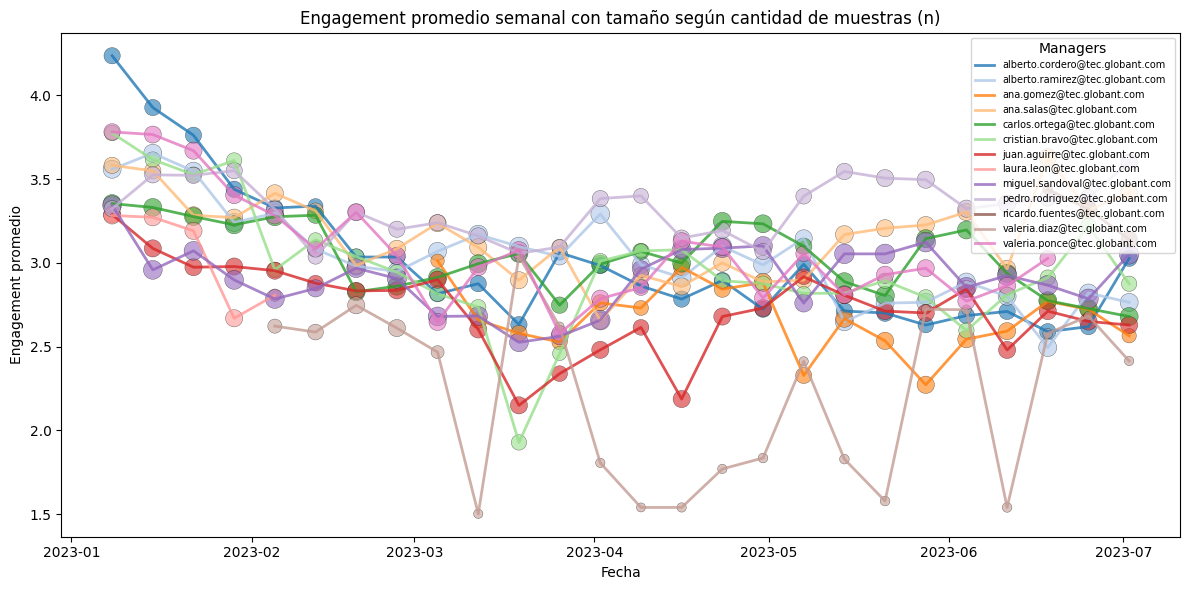

In [26]:
plt.figure(figsize=(12,6))

eng_mgr = (
    data_n
      .set_index("DateDT")
      .groupby("Email Leader")
      .resample("W")
      .agg(
          mean_eng=("Engagement", "mean"),
          n_scores=("Engagement", "size"),   # número de registros
          n_people=("ID", "nunique")         # 👉 número de personas únicas
      )
      .reset_index()
)
# para normalizar el tamaño de los puntos
max_n = eng_mgr["n_scores"].max()

for mid, df_m in eng_mgr.groupby("Email Leader"):
    x = df_m["DateDT"]
    y = df_m["mean_eng"]
    n = df_m["n_scores"]
    
    # escala de tamaños (ajusta los números a tu gusto)
    sizes = 30 + (n / max_n) * 170   # entre 30 y 200

    # línea del promedio
    plt.plot(
        x, y,
        linewidth=2,
        alpha=0.8,
        color=color_map[mid],
        label=str(mid)
    )

    # puntos con tamaño según cantidad de muestras
    plt.scatter(
        x, y,
        s=sizes,
        color=color_map[mid],
        alpha=0.6,
        edgecolor="k",
        linewidth=0.3
    )

plt.title("Engagement promedio semanal con tamaño según cantidad de muestras (n)")
plt.ylabel("Engagement promedio")
plt.xlabel("Fecha")

# leyenda normal de managers
plt.legend(title="Managers", fontsize=7, loc="upper right")
plt.tight_layout()
plt.show()


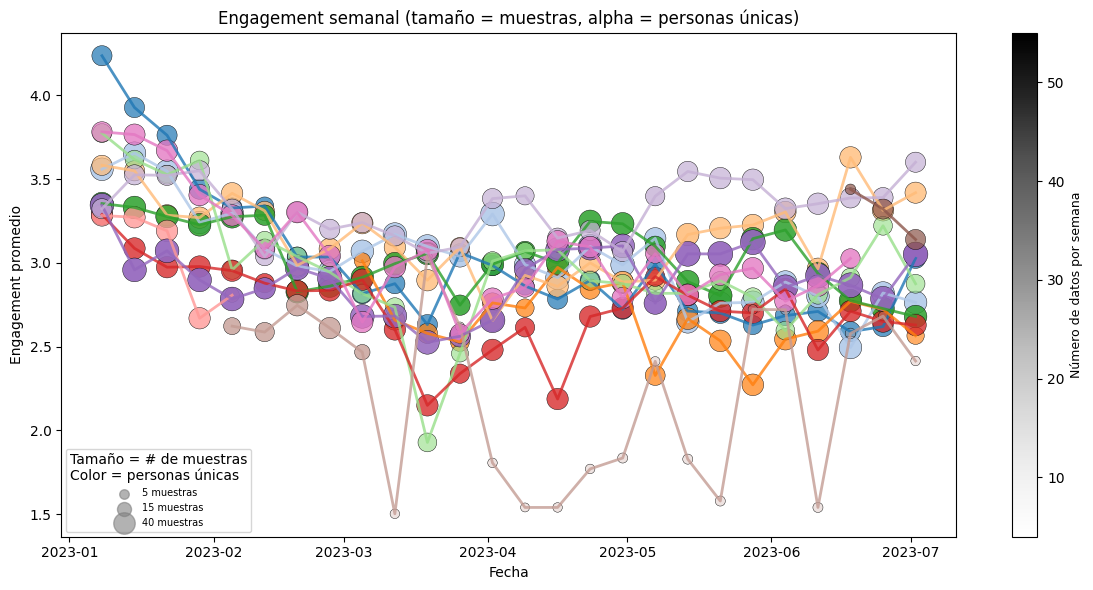

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

max_people = eng_mgr["n_people"].max()   # para alpha
max_scores = eng_mgr["n_scores"].max()   # para tamaño

for mid, df_m in eng_mgr.groupby("Email Leader"):
    
    x = df_m["DateDT"]
    y = df_m["mean_eng"]
    n_people = df_m["n_people"]     # para alpha
    n_scores = df_m["n_scores"]     # para tamaño
    
    sizes = 20 + (n_scores / max_scores) * 300   # ajusta 20 y 300 si deseas

    base_rgba = np.array(mcolors.to_rgba(color_map[mid]))
    colors = []
    for p in n_people:
        c = base_rgba.copy()
        c[3] = 0.20 + 0.80 * (p / max_people)   # alpha 0.2–1.0
        colors.append(c)
    colors = np.vstack(colors)

    ax.plot(x, y, color=color_map[mid], alpha=0.8, linewidth=2)

    ax.scatter(
        x, y,
        s=sizes,
        color=colors,
        edgecolor="k",
        linewidth=0.3
    )


norm = mpl.colors.Normalize(
    vmin=eng_mgr["n_scores"].min(),
    vmax=eng_mgr["n_scores"].max()
)

cmap = mpl.cm.Greys    # Gradiente tipo saturación blanco → gris → negro

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Número de datos por semana", fontsize=9)


size_examples = [5, 15, 40]   
sizes_scaled = [20 + (s / max_scores) * 300 for s in size_examples]

for s, scaled in zip(size_examples, sizes_scaled):
    ax.scatter([], [], s=scaled, color="gray", alpha=0.6,
               label=f"{s} muestras")

ax.legend(
    title="Tamaño = personas únicas \nColor = # de muestras",
    fontsize=7,
    loc="lower left"
)

ax.set_title("Engagement semanal (tamaño = personas únicas, alpha = muestras)")
ax.set_ylabel("Engagement promedio")
ax.set_xlabel("Fecha")

fig.tight_layout()
plt.show()


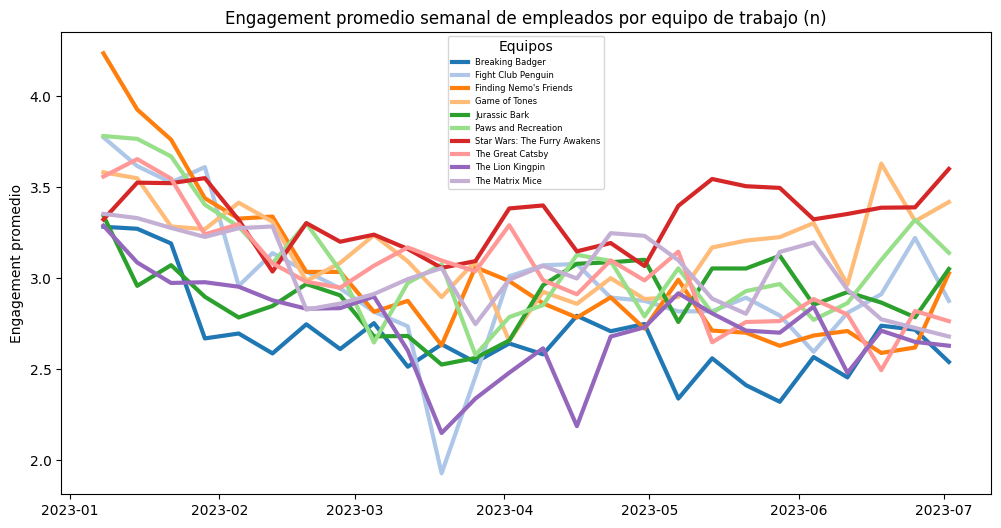

In [ ]:
# Promedio por fecha y Equipo (semanal)
eng_mgr = (data_n.set_index('DateDT').groupby('Team Name')['Engagement']
           .resample('W').mean().reset_index()) # W para que sea semanal (quitar ruido)


teams = eng_mgr['Team Name'].unique()
palette = sns.color_palette("tab20", n_colors=len(teams))
color_map = dict(zip(teams, palette))

plt.figure(figsize=(12,6))

for mid, df_m in eng_mgr.groupby('Team Name'):
    plt.plot(df_m['DateDT'], df_m['Engagement'], alpha=1, linewidth=3, color=color_map[mid], label=str(mid)) # para que no tape todo

plt.title("Engagement promedio semanal de empleados por equipo de trabajo (n)")
plt.ylabel("Engagement promedio")
plt.legend(title="Equipos", fontsize=6)
plt.show()

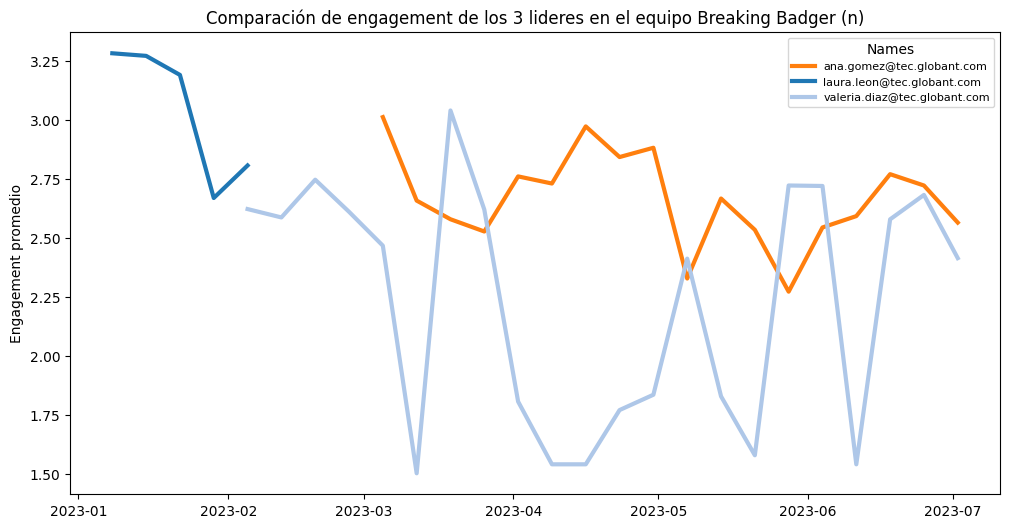

In [ ]:
Lideres_a_comparar = ["laura.leon@tec.globant.com", "valeria.diaz@tec.globant.com", "ana.gomez@tec.globant.com"]
# Promedio por fecha y manager (semanal)
eng_mgr = (data_n.set_index('DateDT').groupby('Email Leader')['Engagement']
           .resample('W').mean().reset_index()) # W para que sea semanal (quitar ruido)


managers = eng_mgr['Email Leader'].unique()
palette = sns.color_palette("tab20", n_colors=len(managers))
color_map = dict(zip(managers, palette))


df_filtro = eng_mgr[ eng_mgr["Email Leader"].isin(Lideres_a_comparar) ]

palette = sns.color_palette("tab20", n_colors=len(Lideres_a_comparar))
color_map = dict(zip(Lideres_a_comparar, palette))

plt.figure(figsize=(12,6))

for team, df_m in df_filtro.groupby("Email Leader"):
    plt.plot(df_m["DateDT"], df_m["Engagement"],
             linewidth=3, alpha=1,
             color=color_map[team],
             label=team)

plt.title("Comparación de engagement de los 3 lideres en el equipo Breaking Badger (n)")
plt.ylabel("Engagement promedio")
plt.legend(title="Names", fontsize=8)
plt.show()


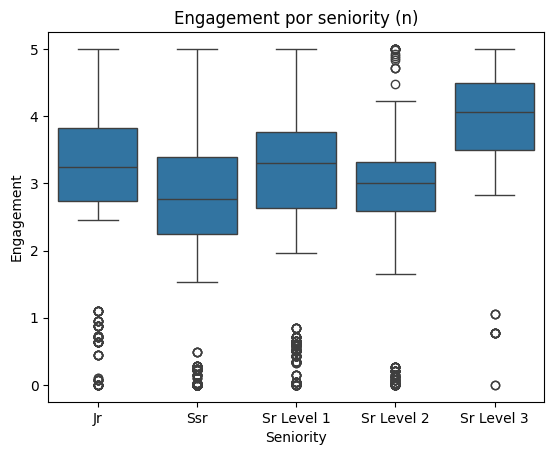

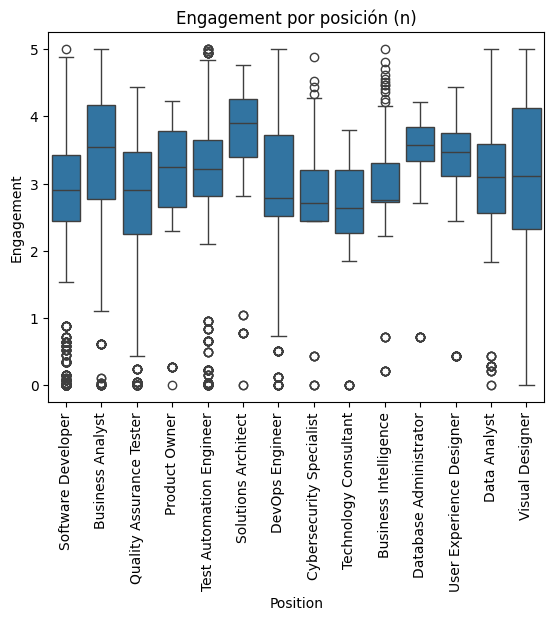

In [ ]:
sns.boxplot(x='Seniority', y='Engagement', data=data_n)
plt.title("Engagement por seniority (n)")
plt.show()

sns.boxplot(x='Position', y='Engagement', data=data_n)
plt.title("Engagement por posición (n)")
plt.xticks(rotation=90)
plt.show()

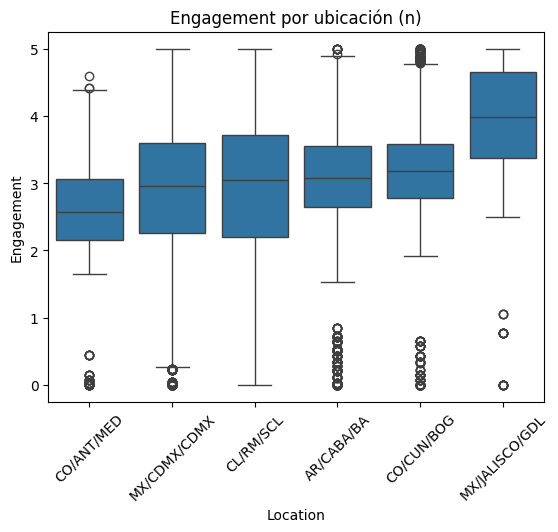

In [ ]:
sns.boxplot(x='Location', y='Engagement', data=data_n)
plt.title("Engagement por ubicación (n)")
plt.xticks(rotation=45)
plt.show()

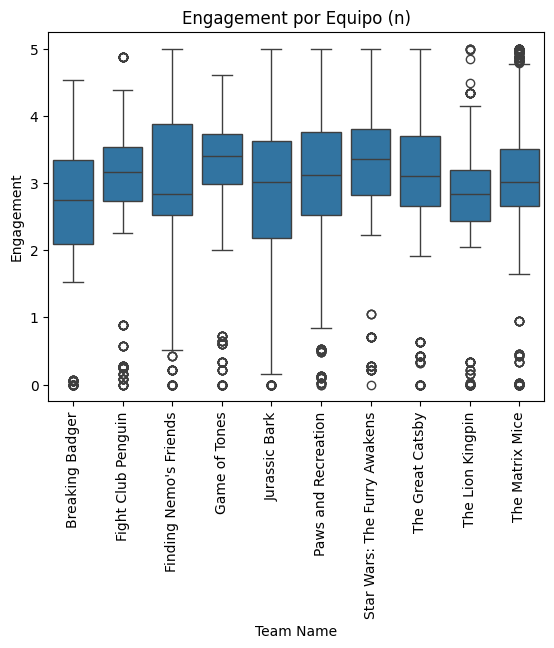

In [ ]:
sns.boxplot(x='Team Name', y='Engagement', data=data_n)
plt.title("Engagement por Equipo (n)")
plt.xticks(rotation=90)
plt.show()

Tomar la mediana del engagement

#tabla de contención
#round a una decima

In [43]:
data_n[data_n['Email Leader'].notnull()]['Engagement'].value_counts()

Engagement
0.00    236
2.65    149
2.52    136
2.74    133
5.00    133
       ... 
1.53      1
1.72      1
4.82      1
1.65      1
1.76      1
Name: count, Length: 370, dtype: int64

soy añañi

Ver el comportamiento de los que se van a engagement 0,  son los que mas bajo tienen el engagement o no

Hacer una cadena para ver las probabilidades de que cambies de puesto dado cierto engagement

In [47]:
# 1. Contar cuántos Seniority distintos tiene cada Email
seniority_por_email = data_n.groupby("Email")["Seniority"].nunique()

# 2. Filtrar solo los emails que tienen más de un Seniority
emails_con_mas_de_un_seniority = seniority_por_email[seniority_por_email > 1]

print(emails_con_mas_de_un_seniority)


Email
felipe.ruiz@tec.globant.com      2
maria.diaz@tec.globant.com       2
sergio.castro@tec.globant.com    2
Name: Seniority, dtype: int64
